# 1. Introduction

To drive a yellow New York taxi, one has to hold a "medallion" from the city's Taxi and Limousine Commission. Recently, one of those changed hands for over one million dollars, which shows how lucrative the job can be.

In the age of business intelligence and analytics, even taxi drivers can stand to benefit from some careful investigation of the data, guiding them to maximize their profits. In this project, I will analyze New York journeys made in 2015. I will also use regression trees and random forests to build a model that can predict the locations and times when the biggest fares can be earned.

Let's start by taking a look at the data.

In [1]:
library(tidyverse)

suppressMessages(taxi <- read_csv("../input/2015-01_100k.csv"))

print(colnames(taxi))
head(taxi)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0.9000     ✔ purrr   0.3.1     
✔ tibble  2.0.1          ✔ dplyr   0.8.0.1   
✔ tidyr   0.8.3          ✔ stringr 1.4.0     
✔ readr   1.3.1          ✔ forcats 0.4.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


 [1] "VendorID"              "pickup_datetime"       "dropoff_datetime"     
 [4] "passenger_count"       "trip_distance"         "pickup_longitude"     
 [7] "pickup_latitude"       "RateCodeID"            "store_and_fwd_flag"   
[10] "dropoff_longitude"     "dropoff_latitude"      "payment_type"         
[13] "fare_amount"           "extra"                 "mta_tax"              
[16] "tip_amount"            "tolls_amount"          "improvement_surcharge"
[19] "total_amount"          "pickup_zip"            "pickup_borough"       
[22] "pickup_neighborhood"   "dropoff_zip"           "dropoff_borough"      
[25] "dropoff_neighborhood" 


VendorID,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,⋯,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_zip,pickup_borough,pickup_neighborhood,dropoff_zip,dropoff_borough,dropoff_neighborhood
2,2015-01-06 11:39:29,2015-01-06 11:49:15,1,1.78,-73.99962,40.74360,1,N,-73.99220,⋯,0.00,0,0.3,9.80,10011,Manhattan,Chelsea and Clinton,10036,Manhattan,Chelsea and Clinton
1,2015-01-13 09:18:29,2015-01-13 09:23:40,1,2.10,-73.98196,40.77829,1,N,-73.96217,⋯,2.45,0,0.3,10.75,10023,Manhattan,Upper West Side,10024,Manhattan,Upper West Side
2,2015-01-16 07:15:44,2015-01-16 07:26:42,1,2.33,-73.99119,40.74223,1,N,-73.98161,⋯,1.00,0,0.3,11.80,10010,Manhattan,Gramercy Park and Murray Hill,10019,Manhattan,Chelsea and Clinton
1,2015-01-23 11:56:05,2015-01-23 12:13:20,1,2.10,-73.95930,40.76334,1,N,-73.98000,⋯,0.00,0,0.3,13.30,10065,Manhattan,Upper East Side,10023,Manhattan,Upper West Side
1,2015-01-24 10:11:48,2015-01-24 10:18:32,2,0.90,-73.97183,40.76475,1,N,-73.98405,⋯,0.00,0,0.3,7.30,10065,Manhattan,Upper East Side,10019,Manhattan,Chelsea and Clinton
1,2015-01-13 12:14:01,2015-01-13 12:37:14,1,4.00,-73.99444,40.75072,1,N,-74.01371,⋯,0.00,0,0.3,18.80,10001,Manhattan,Chelsea and Clinton,10006,Manhattan,Lower Manhattan


As you can see above, the taxi dataset contains the times, price and other information of a large number of taxi trips. Importantly we also get to know the location, the longitude and latitude, where the trip was started.

The taxi dataset needs a bit of polishing before we're ready to use it. I will start by loading all data and keeping only the columns that I require. Then I will drop any journeys with zero trip amount, and change certain column names. Lastly, I will zoom in on Manhattan using latitude from 40.70 to 40.83 and longitude from -74.025 to -73.93.

In [2]:
columns <- c('VendorID', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'total_amount')

taxi <- taxi %>%
        select(columns)

taxilist <- list()

for (i in 2:12){
    if (i < 10){
        suppressMessages(taxilist[[i]] <- read_csv(paste("../input/2015-0", i, "_100k.csv", sep = ''))) 
    }
    else {
        suppressMessages(taxilist[[i]] <- read_csv(paste("../input/2015-", i, "_100k.csv", sep = '')))
    }
    taxilist[[i]] <- taxilist[[i]] %>%
                    select(columns)
    
    taxi <- rbind(taxi, taxilist[[i]])
}

taxi <- taxi %>%
   rename(lat = pickup_latitude, long = pickup_longitude) %>%
   filter(total_amount > 0)

taxi <- taxi  %>% 
    filter(between(lat, 40.70, 40.83) & between(long, -74.025, -73.93))

It's time to draw a map! I'm going to use the ggmap package together with ggplot2 to visualize where in Manhattan people tend to start their taxi journeys.

Google's Terms of Service: https://cloud.google.com/maps-platform/terms/.
Please cite ggmap if you use it! See citation("ggmap") for details.
Loading required package: viridisLite


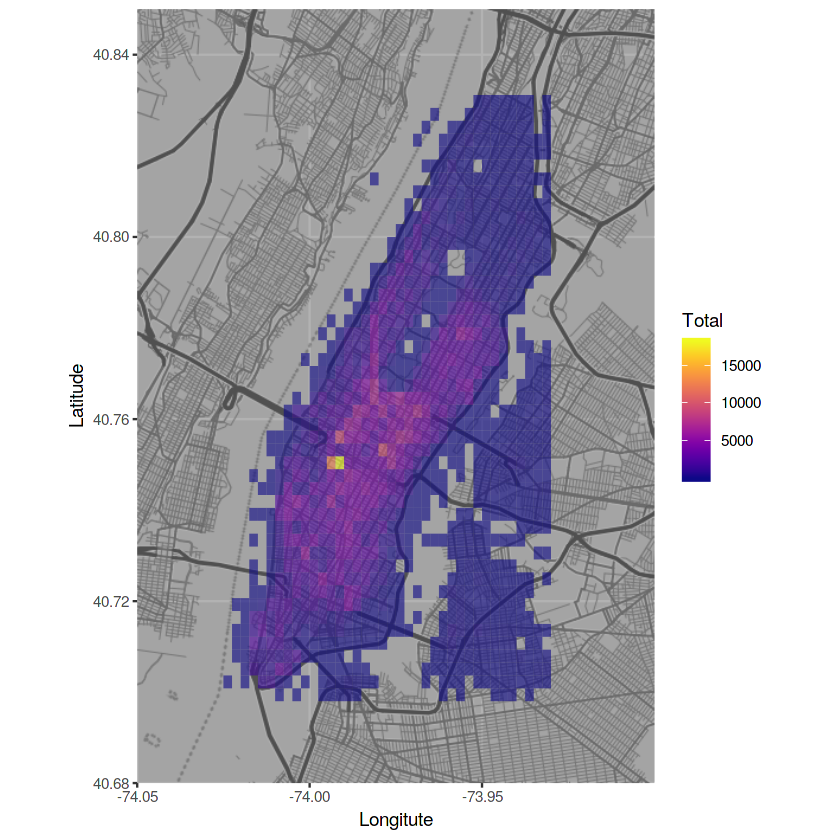

In [3]:
library(ggmap)
library(viridis)

suppressMessages(manhattan <- get_stamenmap(bbox = c(left = -74.05, bottom = 40.68, 
                                                     right = -73.90, top = 40.85),
                           maptype = 'terrain-lines', zoom = 12, color = "bw"))

ggmap(manhattan, darken = 0.3) +
   scale_fill_viridis(option = 'plasma') +
   geom_bin2d(data = taxi, aes(x = long, y = lat), bins = 60, alpha = 0.6) +
   labs(x = "Longitute", y = "Latitude", fill = "Total")

The map shows that the journeys are highly concentrated in the business and tourist areas. We also see that some taxi trips originating in Brooklyn slipped through, but that's fine.



# 2. Using Regression Trees
I'm now going to use a regression tree to predict the total fare with `lat` and `long` being the predictors. The tree algorithm will try to find cutpoints in those predictors that results in the decision tree with the best predictive capability. 

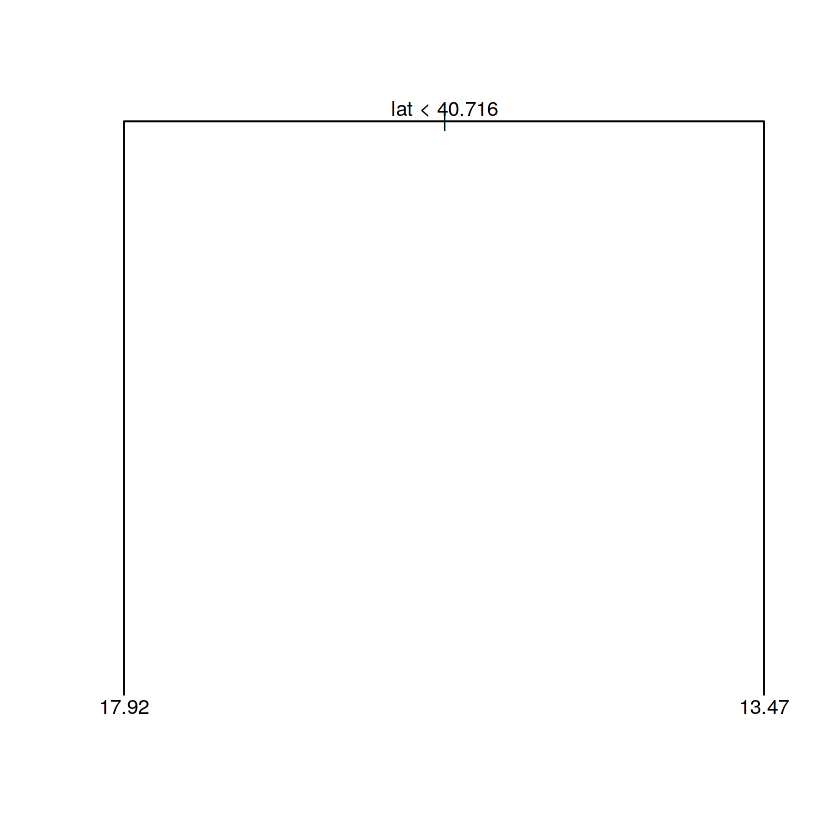

In [4]:
library(tree)

fitted_tree <- tree(total_amount ~ lat + long, taxi)

plot(fitted_tree)
text(fitted_tree)

The tree above looks a bit frugal, it only includes one split: It predicts that trips where `lat` < 40.716 are more expensive, which makes sense as it is downtown Manhattan. But that's it. It didn't even include `long` as the tree deemed that it didn't improve the predictions.

Let's start by adding some more predictors related to the time the taxi trip was made.


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date




Regression tree:
tree(formula = total_amount ~ lat + long + hour + wday + month, 
    data = taxi)
Variables actually used in tree construction:
[1] "lat"
Number of terminal nodes:  2 
Residual mean deviance:  64.86 = 74220000 / 1144000 
Distribution of residuals:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -17.61   -5.17   -2.17    0.00    2.49  351.70 

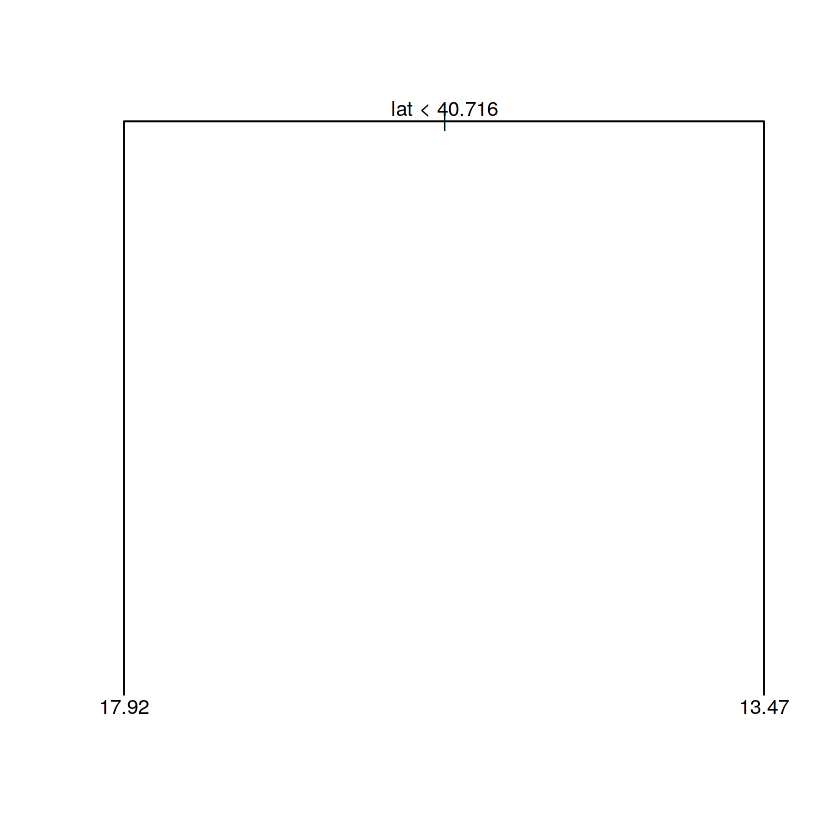

In [5]:
library(lubridate)

taxi <- taxi %>% 
    mutate(hour = hour(pickup_datetime), 
           wday = wday(pickup_datetime, label = TRUE), 
           month = month(pickup_datetime, label = TRUE))

fitted_tree <- tree(total_amount ~ lat + long + hour + wday + month, taxi)

plot(fitted_tree)
text(fitted_tree)

summary(fitted_tree)

The regression tree has not changed after including the three time variables. This is likely because latitude is still the most promising first variable to split the data on, and after that split, the other variables are not informative enough to be included. 

# 3. Random Forests
A random forest model, where many different trees are fitted to subsets of the data, may well include the other variables in some of the trees that make it up. 

In [6]:
library(randomForest)

fitted_forest <- randomForest(total_amount ~ lat + long + hour + wday + month, 
                              taxi, ntree = 80, sampsize = 10000)

print(fitted_forest)

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin




Call:
 randomForest(formula = total_amount ~ lat + long + hour + wday +      month, data = taxi, ntree = 80, sampsize = 10000) 
               Type of random forest: regression
                     Number of trees: 80
No. of variables tried at each split: 1

          Mean of squared residuals: 63.44366
                    % Var explained: 3.45


In the output of `fitted_forest` we see the `Mean of squared residuals`, that is, the average of the squared errors the model makes. If you scroll up and check the summary of `fitted_tree` you'll find `Residual mean deviance` which is the same number. If you compare these numbers, you'll see that `fitted_forest` has a slightly lower error. Neither predictive model is that good, in statistical terms, they explain only about 3% of the variance.

Now, let's take a look at the predictions of `fitted_forest` projected back onto Manhattan.

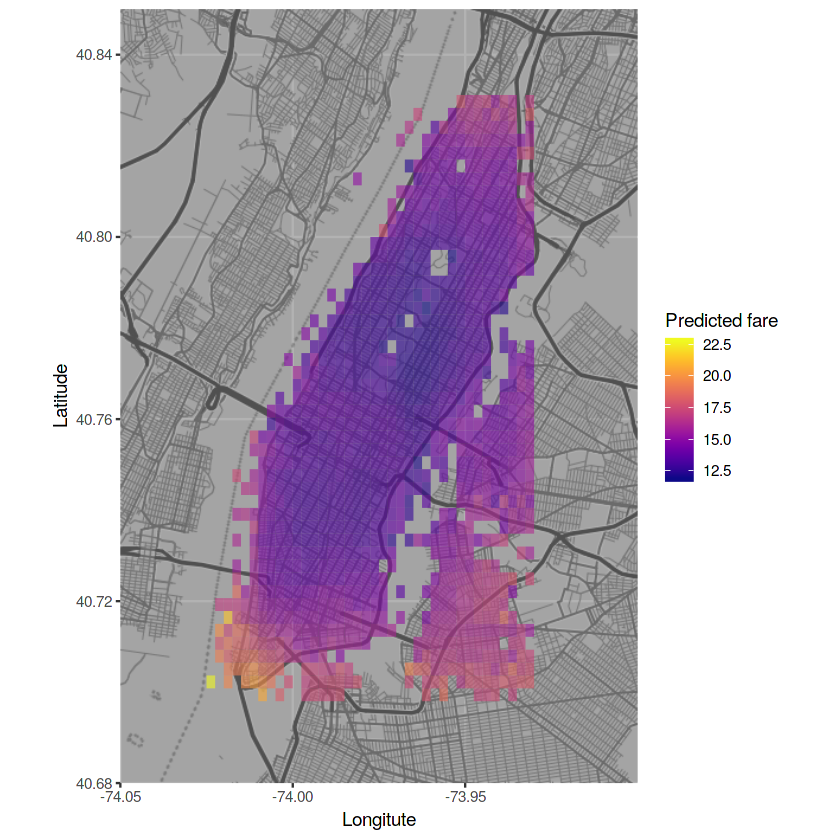

In [7]:
taxi$pred_total <- fitted_forest$predicted

ggmap(manhattan, darken = 0.3) +
   scale_fill_viridis(option = 'plasma') +
   stat_summary_2d(data = taxi, aes(x = long, y = lat, z = pred_total),
                   fun = mean, bins = 60, alpha = 0.6) +
   labs(x = "Longitute", y = "Latitude", fill = "Predicted fare")

Looking at the map with the predicted fares we see that fares in downtown Manhattan are predicted to be high, while midtown is lower. Now, let's compare the map with the predicted fares with a new map showing the mean fares according to the data.

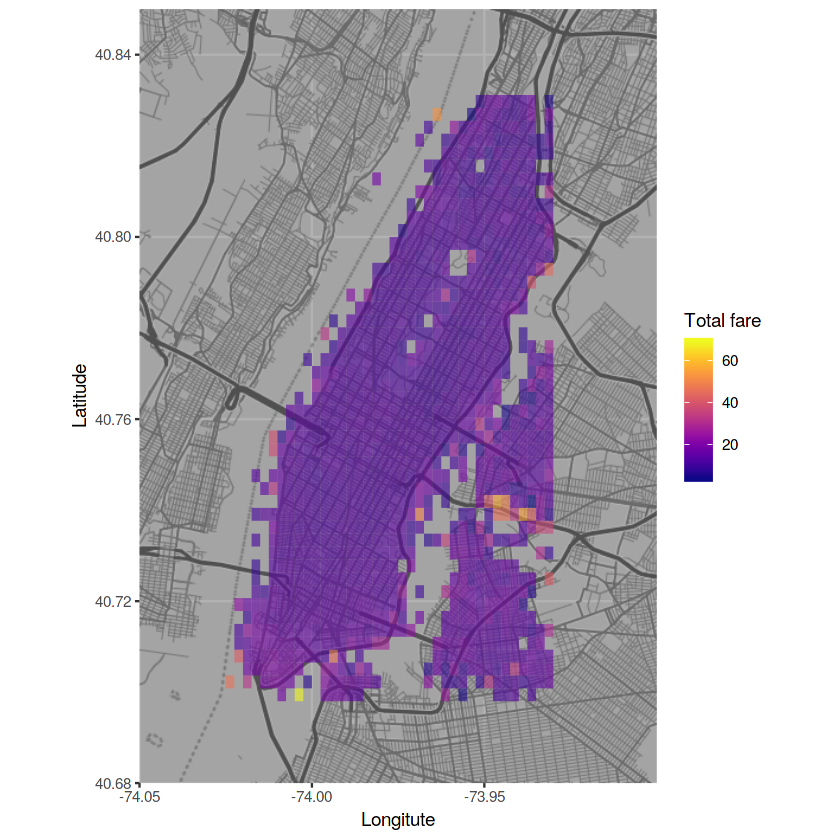

In [8]:
ggmap(manhattan, darken = 0.3) +
   scale_fill_viridis(option = 'plasma') +
   stat_summary_2d(data = taxi, aes(x = long, y = lat, z = total_amount),
                   fun = "mean", bins = 60, alpha = 0.6) +
   labs(x = "Longitute", y = "Latitude", fill = "Total fare")

So it looks like the random forest model captured some of the patterns in our data. Finally, let us look at variation of the predictions with time. For this, first I will group the data by `hour` and calculate the average fare for this time group.

In [9]:
taxi <- taxi %>%
            group_by(hour) %>%
            mutate(pred_per_hour = mean(pred_total, na.rm = TRUE)) %>%
            mutate(per_hour = mean(total_amount, na.rm = TRUE))

Next, I will plot this data in a line plot, to see the the differences between predicted and actual fares with respect to different times. A similar analysis can be done for weekdays and months.

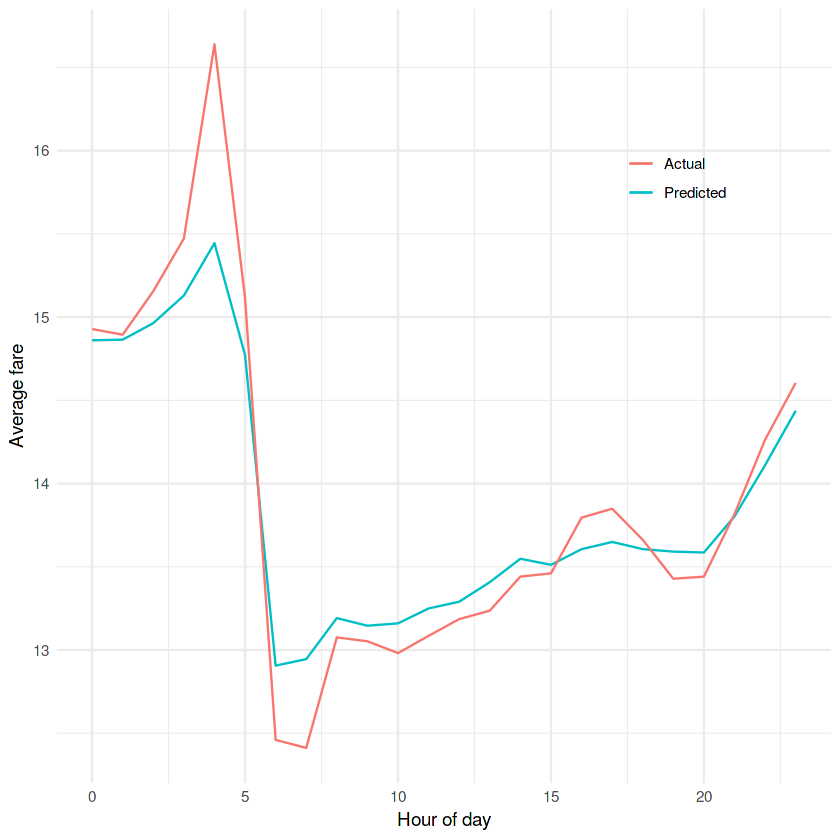

In [10]:
colors <- rainbow(2)

ggplot(taxi, aes(x = hour)) + 
    geom_line(aes(y = pred_per_hour, colour = colors[1])) + 
    geom_line(aes(y = per_hour, colour = colors[2])) +
    scale_color_discrete(name ='', labels = c("Actual", "Predicted")) +
    labs(x = "Hour of day", y = "Average fare") +
    theme_minimal() + 
    theme(legend.position = c(0.8, 0.8));